<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  Capstone Project: Train Delays Predictor
---

### Problem Statement and Solution Approach:

**Problem:**<br>
Despite ongoing efforts to improve the MRT system, train delays and faults persist, causing frustration and inconvenience for passengers.

**Proposed Solution:**<br>As a daily commuter of Singapore MRT, I aim to develop a train delays predictor that can identify stations and timings that are more likely to experience breakdowns or delays. 

By analyzing historical data on time of day, type of day, station name, commuter volume, and breakdown/non-breakdown indicators, I hope to create a model that can accurately predict future breakdowns and help commuters avoid stations and times with potential delays.

### Data used:
Data used in the analysis consists of SMRT information from the Land Transport Authorithy and SMRT tweets about train faults scrapped from SMRT Twitter profile page. Please rerefer to the data dictionary for more information on the columns extracted.

### Data Collection
Refer to **1. Data Collection** notebook.

### Data Cleaning and Analysis
Refer to **2. Data Cleaning and Analysis** notebook.

## 3. Data Modelling: Selection & Validation


### Context:
Model selection & validation:

1. I will be running the 5 classification models to try to predict which stations are more likely to experience delays or faults based on the given features.

2. Based on the results of all the models, I will choose the model with the best accuracy to create my predictor.

In [11]:
# Import Dependencies

# Basic
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

# Model related
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Resampling due to imbalance target variable
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Machine learning training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Table formatting
from tabulate import tabulate

# Saving model
import pickle

## Model selection

**Classification Models:**

1. Random Forest 
2. Decision Tree 
3. KNN 
4. Logistics regresssion
5. XG Boost

**Load csv**

In [159]:
# Load data
data = pd.read_csv("final_smrt.csv")
data

C:\Users\qiyua\AppData\Local\Temp\ipykernel_26340\3516164388.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("final_smrt.csv")


,year_month,day_type,time_per_hour,pt_code,station_name,total_tap_in_volume,total_tap_out_volume,fault,fault_type,traffic_volume,traffic_level
0,2023-02,WEEKDAY,10,NS9/TE2,WOODLANDS,26154.000000,21708.000000,Y,train,47862.00,4
1,2023-02,WEEKDAY,10,NS10,ADMIRALTY,26951.000000,11745.000000,Y,train,38696.00,4
2,2023-02,WEEKDAY,10,NS11,SEMBAWANG,23289.000000,10574.000000,Y,train,33863.00,4
3,2023-02,WEEKDAY,10,NS12,CANBERRA,8570.000000,4132.000000,Y,train,12702.00,1
4,2023-02,WEEKDAY,10,NS13,YISHUN,30527.000000,19727.000000,Y,train,50254.00,4
...,...,...,...,...,...,...,...,...,...,...,...
424028,2018-01,WEEKDAY,8,DT30,BEDOK RESERVOIR,14028.150710,16670.265361,N,NaN,30698.42,4
424029,2018-01,WEEKDAY,7,DT30,BEDOK RESERVOIR,13893.080245,16477.385058,N,NaN,30370.47,4
424030,2018-01,WEEKDAY,6,DT30,BEDOK RESERVOIR,13758.009780,16284.504754,N,NaN,30042.51,4
424031,2018-01,WEEKDAY,5,DT30,BEDOK RESERVOIR,13622.939315,16091.624451,N,NaN,29714.56,4


In [160]:
# Dropping irrelevant columns
data.drop(['total_tap_in_volume', 'total_tap_out_volume','pt_code','fault_type','traffic_volume', 'traffic_level'], axis = 1, inplace = True)

# Display
data

,year_month,day_type,time_per_hour,station_name,fault
0,2023-02,WEEKDAY,10,WOODLANDS,Y
1,2023-02,WEEKDAY,10,ADMIRALTY,Y
2,2023-02,WEEKDAY,10,SEMBAWANG,Y
3,2023-02,WEEKDAY,10,CANBERRA,Y
4,2023-02,WEEKDAY,10,YISHUN,Y
...,...,...,...,...,...
424028,2018-01,WEEKDAY,8,BEDOK RESERVOIR,N
424029,2018-01,WEEKDAY,7,BEDOK RESERVOIR,N
424030,2018-01,WEEKDAY,6,BEDOK RESERVOIR,N
424031,2018-01,WEEKDAY,5,BEDOK RESERVOIR,N


## Model Validation

**1. Identifying features and target**

In [161]:
# Replacing target variable to numerical
data['fault'] = data['fault'].replace({'N': 0, 'Y': 1})

# Identifying features
feature_cols = ["day_type", "time_per_hour", "station_name"]
target = 'fault'

**2. Imbalance class for target variable**

In [162]:
# Split the dataset into features (X) and target variable (y)
X = data[feature_cols]
y = data[target]

# calculate the baseline accuracy:
y.value_counts()/y.count()*100

0    99.782564
1     0.217436
Name: fault, dtype: float64

**3. Split data into train test sets**

In [163]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**4. Balancing target variable**

In [164]:
# Resample target variable
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled1, y_train_resampled = rus.fit_resample(X_train, y_train)

# Print the number of samples in each class
print(pd.Series(y_train_resampled).value_counts())

0    695
1    695
Name: fault, dtype: int64


**5. Dummifying categorical columns**

In [165]:
# Identify categorical columns
cat_cols = ["day_type", "station_name"]

# Dummify categorical columns
X_train_resampled = pd.get_dummies(X_train_resampled1, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

In [166]:
X_train_resampled

,time_per_hour,day_type_WEEKDAY,day_type_WEEKENDS/HOLIDAY,station_name_ADMIRALTY,station_name_ALJUNIED,station_name_ANG MO KIO,station_name_BAKAU,station_name_BANGKIT,station_name_BARTLEY,station_name_BAYFRONT,...,station_name_UBI,station_name_UPPER CHANGI,station_name_UPPER THOMSON,station_name_WOODLANDS,station_name_WOODLANDS NORTH,station_name_WOODLANDS SOUTH,station_name_WOODLEIGH,station_name_YEW TEE,station_name_YIO CHU KANG,station_name_YISHUN
0,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,10,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1386,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1387,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1388,19,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**6. Train the models**

In [168]:
# Set random seed for reproducibility
random_seed = 42

# Create a list of models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_seed)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5, random_state=random_seed)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Logistic Regression', LogisticRegression(random_state=random_seed)),
    ('XG Boost', XGBClassifier())
]

# Initialize empty lists to store the results
train_scores = []
test_scores = []
train_times = []

# Loop over each model
for model_name, model in models:
    # Start timing
    start_time = time.time()

    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Get the predicted values for testing sets
    y_test_pred = model.predict(X_test)

    # Calculate the accuracy scores for both training and testing sets
    train_score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    test_score = accuracy_score(y_test, y_test_pred)

    # Calculate the training time
    end_time = time.time()
    train_time = end_time - start_time

    # Append the results to the lists
    train_scores.append(train_score.mean())
    test_scores.append(test_score)
    train_times.append(train_time)

# Create a pandas dataframe to store the results
results_df = pd.DataFrame({
    'Model': [model_name for model_name, _ in models],
    'Train Accuracy': train_scores,
    'Test Accuracy': test_scores,
    'Train Time (seconds)': train_times
})

# Print the results in a tabular format
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------+------------------------+
|    | Model               |   Train Accuracy |   Test Accuracy |   Train Time (seconds) |
|----+---------------------+------------------+-----------------+------------------------|
|  0 | Random Forest       |         0.685612 |        0.55684  |               3.88162  |
|  1 | Decision Tree       |         0.680576 |        0.621004 |               0.241357 |
|  2 | KNN                 |         0.68777  |        0.639832 |              11.1906   |
|  3 | Logistic Regression |         0.738129 |        0.72458  |               0.533574 |
|  4 | XG Boost            |         0.742446 |        0.750512 |               5.32277  |
+----+---------------------+------------------+-----------------+------------------------+


**7. Tuning models:**

**Using Grid search to find the optimal hyperparameters for the each models**


In [175]:
# Grid search 

# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rfc_gs = GridSearchCV(rfc, param_grid=rfc_params, cv=5, n_jobs=-1)
rfc_gs.fit(X_train_resampled, y_train_resampled)

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc_params = {'max_depth': [5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

dtc_gs = GridSearchCV(dtc, param_grid=dtc_params, cv=5, n_jobs=-1)
dtc_gs.fit(X_train_resampled, y_train_resampled)

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

knn_gs = GridSearchCV(knn, param_grid=knn_params, cv=5, n_jobs=-1)
knn_gs.fit(X_train_resampled, y_train_resampled)

# Logistic Regression Classifier
lr = LogisticRegression(random_state=42)
lr_params = {'penalty': ['l1', 'l2'],
             'C': [0.1, 1, 10],
             'solver': ['liblinear']}

lr_gs = GridSearchCV(lr, param_grid=lr_params, cv=5, n_jobs=-1)
lr_gs.fit(X_train_resampled, y_train_resampled)

# XG Boost Classifier

# Create the XGBClassifier object
xgb_model = XGBClassifier()

# Define the hyperparameters to tune
xgb_param = {'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.01, 0.001],
              'subsample': [0.5, 0.7, 1.0],
              'colsample_bytree': [0.5, 0.7, 1.0]}

# Create the GridSearchCV object
xgb_gs = GridSearchCV(xgb_model, param_grid=xgb_param, cv=5)

# Fit the GridSearchCV object to the data
xgb_gs.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.5, 0.7, 1.0]})

In [176]:
# Print the best parameters and score
print('Random Forest Classifier:')
print('Best parameters:', rfc_gs.best_params_)
print('Best score:', rfc_gs.best_score_,'\n')

print('Decision Tree Classifier:')
print('Best parameters:', dtc_gs.best_params_)
print('Best score:', dtc_gs.best_score_,'\n')

print('KNN Classifier:')
print('Best parameters:', knn_gs.best_params_)
print('Best score:', knn_gs.best_score_,'\n')

print('Logistic Regression Classifier:')
print('Best parameters:', lr_gs.best_params_)
print('Best score:', lr_gs.best_score_,'\n')

print('XG Boost Classifier:')
print('Best parameters:', xgb_gs.best_params_)
print('Best score:', xgb_gs.best_score_)

Random Forest Classifier:
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best score: 0.7093525179856115 

Decision Tree Classifier:
Best parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.6856115107913668 

KNN Classifier:
Best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}
Best score: 0.6884892086330935 

Logistic Regression Classifier:
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.7381294964028776 

XG Boost Classifier:
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
Best score: 0.7561151079136691


**8. Re-training all models using the optimal hyperparameters**

In [177]:
# Re-define models with the optimised hyperparameters using Grid Search

rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=1, min_samples_split=5,random_state=random_seed)
dt = DecisionTreeClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=2,random_state=random_seed)
knn = KNeighborsClassifier(n_neighbors=7, algorithm='brute', weights='uniform')
lr = LogisticRegression(penalty='l2', C=1, solver='liblinear',random_state=random_seed)
xgb = XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7)

In [178]:
# create a list of the models
models = [('Random Forest', rf), ('Decision Tree', dt), ('KNN', knn), ('Logistic Regression', lr), ('XG Boost', xgb)]

# Initialize empty lists to store the results
train_scores = []
test_scores = []
train_times = []

# Loop over each model
for model_name, model in models:
    # Start timing
    start_time = time.time()

    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Get the predicted values for testing sets
    y_test_pred = model.predict(X_test)

    # Calculate the accuracy scores for both training and testing sets
    train_score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    test_score = accuracy_score(y_test, y_test_pred)

    # Calculate the training time
    end_time = time.time()
    train_time = end_time - start_time

    # Append the results to the lists
    train_scores.append(train_score.mean())
    test_scores.append(test_score)
    train_times.append(train_time)

# Create a pandas dataframe to store the results
results_df = pd.DataFrame({
    'Model': [model_name for model_name, _ in models],
    'Train Accuracy': train_scores,
    'Test Accuracy': test_scores,
    'Train Time (seconds)': train_times
})

# Print the results in a tabular format
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------+------------------------+
|    | Model               |   Train Accuracy |   Test Accuracy |   Train Time (seconds) |
|----+---------------------+------------------+-----------------+------------------------|
|  0 | Random Forest       |         0.709353 |        0.588733 |              19.0471   |
|  1 | Decision Tree       |         0.685612 |        0.69346  |               0.298203 |
|  2 | KNN                 |         0.688489 |        0.652048 |              23.1885   |
|  3 | Logistic Regression |         0.738129 |        0.724457 |               0.530581 |
|  4 | XG Boost            |         0.756115 |        0.77834  |              42.2764   |
+----+---------------------+------------------+-----------------+------------------------+


#### Based on the accuracy percentages, XG Boost is the best model, but the run time is too long to be efficient. 

#### Hence, looking for a faster run time, I will only zoom into Decision Tree and Logistic Regression.

#### I will be selecting Logistic Regression over Decision Tree given that it has the higher accuracy of 72.4% and with a reasonable run time of less than one second.

9. Additional understanding on the learning curve of each model 

In [180]:
# Define learning curve plotting functions
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\qiyua\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

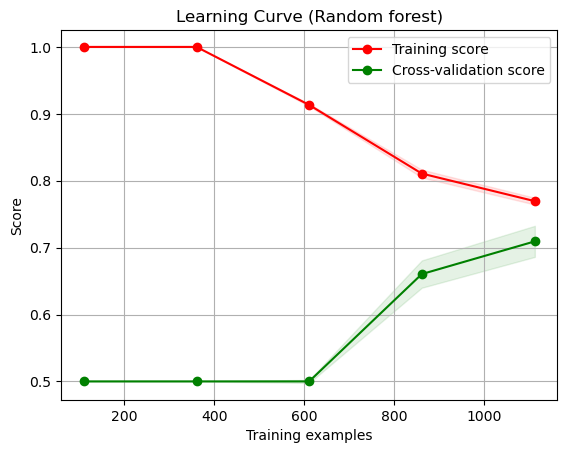

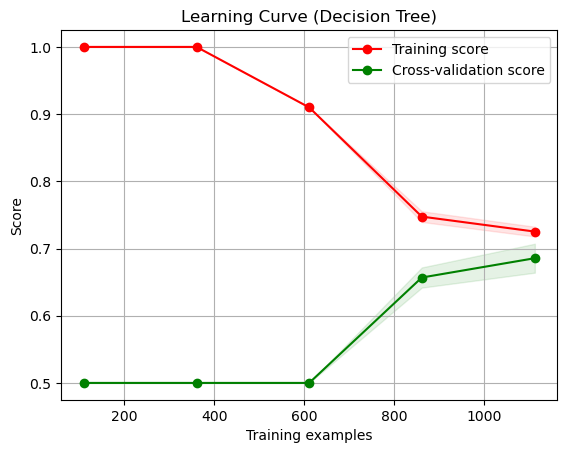

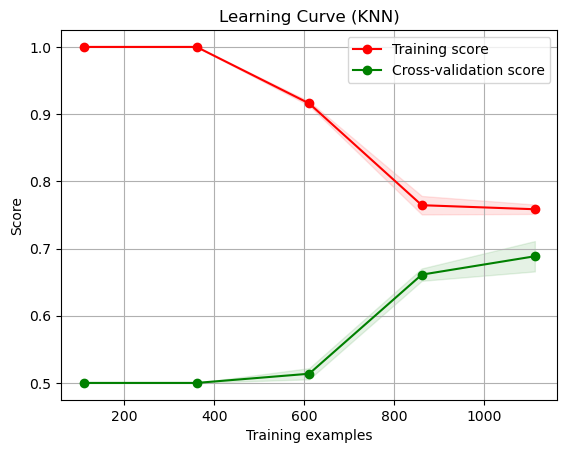

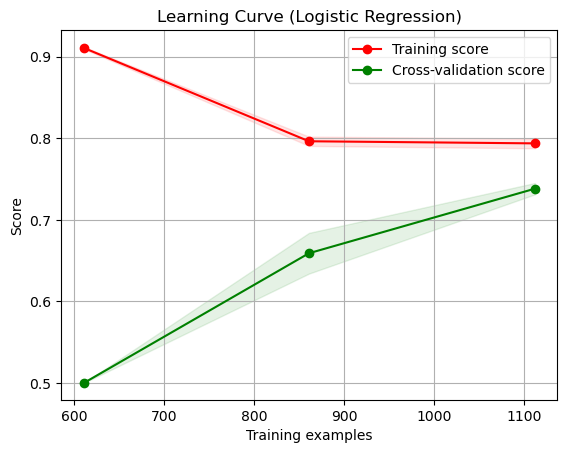

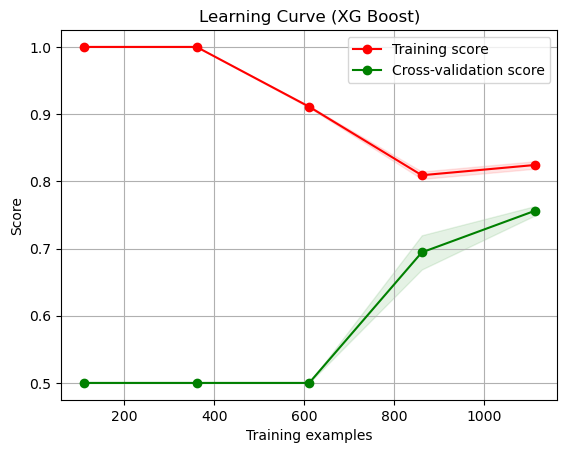

In [181]:
# Plots for each model
plot_learning_curve(rf, "Learning Curve (Random forest)", X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
plot_learning_curve(dt, "Learning Curve (Decision Tree)", X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
plot_learning_curve(knn, "Learning Curve (KNN)", X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
plot_learning_curve(lr, "Learning Curve (Logistic Regression)", X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
plot_learning_curve(xgb, "Learning Curve (XG Boost)", X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)

**10. Saving the best models for model deployment**

In [196]:
# save the model to disk

lr_file = 'finalized_model.pkl'
pickle.dump(lr, open(lr_file, 'wb'))

**11. Defining function to get output (target variable) based on user's input (features)**

In [26]:
def getPredictOutput():
    user_input = input("please enter time_per_hour,day_type, station_name in order (use comma as delimiter):")
    user_input = user_input.split(',')
    d= {}
    pickled_model = pickle.load(open(r'C:\Users\qiyua\Desktop\QIYUAN\CAREER & COURSES\TFIP\TFIP_General Assembly\Course materials\CAPSTONE PROJECT\Streamlit\finalized_model.pkl', 'rb'))
    for x in pickled_model.feature_names_in_.tolist():
        d[x] = [0]
    d['time_per_hour'] = int(user_input[0])
    if user_input[1].upper() == 'WEEKDAY':
        d['day_type_WEEKDAY'][0] = 1
    else:
        d['day_type_WEEKENDS/HOLIDAY'][0] = 1
    station = "station_name_" + user_input[2].upper()
    d[station][0] = 1
    modelInput = pd.DataFrame(d)
    result = pickled_model.predict(modelInput)
    print(result)
    print(int(result[0]))
    print(type(result[0]) == int)
    

In [27]:
getPredictOutput()

please enter time_per_hour,day_type, station_name in order (use comma as delimiter):7,weekday,marsiling
[1]
1
False


In [ ]:
7,weekday,marsiling